# Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from datetime import datetime, date
from sklearn.metrics import r2_score

2024-11-28 20:59:23.314530: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-28 20:59:23.317250: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-28 20:59:23.324679: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-28 20:59:23.339205: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-28 20:59:23.342568: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 20:59:23.353164: I tensorflow/core/platform/cpu_feature_gu

# Input data - dropping date and bitcoin opening, high and low prices

In [2]:
data = pd.read_csv('/home/hoangbaoan1901/Documents/information-system_UET/sem5/prdan/Homeworks/week-3-btl/datasets/jrfm-2156907-cleaned.csv')

In [3]:
data['Date'] = pd.to_datetime(data['Date'])
data = data[['Date', 'BTC_Close', 'BTC_High', 'BTC_Low', 'BTC_Open']]

In [4]:
data.head()

,Date,BTC_Close,BTC_High,BTC_Low,BTC_Open
0,2015-08-07,279.584991,280.391998,276.365997,278.740997
1,2015-08-08,260.997009,279.928009,260.709991,279.742004
2,2015-08-09,265.083008,267.002991,260.467987,261.115997
3,2015-08-10,264.470001,267.032013,262.596008,265.477997
4,2015-08-11,270.385986,270.385986,264.093994,264.342010


In [5]:
data.shape

(2430, 5)

In [6]:
data.isna().sum()

Date         0
BTC_Close    0
BTC_High     0
BTC_Low      0
BTC_Open     0
dtype: int64

# Split data into train and test set

In [7]:
start_day_p2 = pd.Timestamp(2018, 10, 1)
test_day_p2 = pd.Timestamp(2021, 10, 1)
end_day_p2 = pd.Timestamp(2022, 4, 1)

period2 = data[(data["Date"] <= end_day_p2)].reset_index(drop = True)
train_dataset_p2 = period2[period2["Date"] < test_day_p2].reset_index(drop = True)
test_dataset_p2 = period2[period2["Date"] >= test_day_p2].reset_index(drop = True)
train_dataset_p2 = train_dataset_p2.drop(columns = ["Date"])
test_dataset_p2 = test_dataset_p2.drop(columns = ["Date"])

In [8]:
# Define the target variable
target = 'BTC_Close'

# Create the feature sets
X_train = train_dataset_p2[:-1]
X_test = test_dataset_p2[:-1]

# Create the target sets
Y_train = train_dataset_p2[target][1:]
Y_test = test_dataset_p2[target][1:]

X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)


X_train shape: (2246, 4)
X_test shape: (182, 4)
Y_train shape: (2246,)
Y_test shape: (182,)


# Normalize data with MinMaxScaler

In [9]:
# Normalize the datasets using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both train and test data
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Update the variables used for training
X_train = X_train_scaled
X_test = X_test_scaled

print(len(X_train))

2246


# Model initialization & compilation

In [10]:
import keras_tuner as kt


def mlp_builder(hp):
    tf.keras.backend.clear_session()
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))
    hp_no_layers = hp.Int('no_layers', min_value=1, max_value=2, step=1)
    for i in range(hp_no_layers):
        hp_no_units = hp.Choice(f'no_units_{i}', values=[64, 128, 256])
        model.add(tf.keras.layers.Dense(units=hp_no_units, activation='relu'))
        hp_no_dropout = hp.Float(
            f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)
        model.add(tf.keras.layers.Dropout(hp_no_dropout))
    hp_last_units = hp.Choice('last_units', values=[64, 128, 256])
    model.add(tf.keras.layers.Dense(units=hp_last_units, activation='relu'))
    hp_last_dropout = hp.Float(
        'last_dropout', min_value=0.1, max_value=0.5, step=0.1)
    model.add(tf.keras.layers.Dropout(hp_last_dropout))
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    return model


tuner = kt.Hyperband(mlp_builder,
                     objective='val_loss',
                     max_epochs=100,
                     factor=3,
                     directory='/home/hoangbaoan1901/Documents/information-system_UET/sem5/prdan/tianen101/implementations/experiments/hyperparam_tuning',
                     project_name='mlp_all')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Reloading Tuner from /home/hoangbaoan1901/Documents/information-system_UET/sem5/prdan/tianen101/implementations/experiments/hyperparam_tuning/mlp_all/tuner0.json


In [11]:
tuner.search(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test), callbacks=[stop_early])

In [12]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test), callbacks=[stop_early])
val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print(f"Best epoch: {best_epoch}")

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 283883872.0000 - val_loss: 2425797888.0000
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 302867168.0000 - val_loss: 1880360832.0000
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 172792880.0000 - val_loss: 356945760.0000
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 55553700.0000 - val_loss: 140271264.0000
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 26503456.0000 - val_loss: 30958130.0000
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 12425405.0000 - val_loss: 11582012.0000
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 7825786.0000 - val_loss: 9532310.0000
Epoch 8/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6227765.0000 - val_loss: 5246755.0000
Epoch 9/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 5893008.5000 - val_loss: 7247720.0000
Epoch 10/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 5519520.5000 - val_loss: 5639411.5

In [13]:
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(X_train, Y_train, epochs=best_epoch)

Epoch 1/16
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 929us/step - loss: 310502688.0000
Epoch 2/16
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 269393952.0000
Epoch 3/16
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 147405152.0000
Epoch 4/16
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 41733884.0000
Epoch 5/16
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 19550778.0000
Epoch 6/16
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 9076286.0000
Epoch 7/16
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 6285955.5000
Epoch 8/16
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 7142112.5000
Epoch 9/16
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 6472255.0000
Epoch 10/16
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 6459718.5000
Epoch 11/16
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 5410594.5000
Epoch 12/16
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 6972447.5000
Epoch 13/16
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - loss: 5807608.0000
Epoch 14/16
71/71 ━━━━━━━━━━━━━━━━━━━━ 

In [14]:
# Plot the result
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error

def directional_accuracy(y_true, y_pred):
	y_test_da = np.array(y_true)
	y_pred_0 = y_pred[1:] - y_test_da[:-1]
	y_test_0 = y_true[1:] - y_test_da[:-1]
	DA = (y_pred_0<0) == (y_test_0<0)
	return np.mean(DA)*100

Y_pred = hypermodel.predict(X_test)
r2 = r2_score(Y_test, Y_pred)
rmse = root_mean_squared_error(Y_test, Y_pred)
da = directional_accuracy(Y_test, Y_pred)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


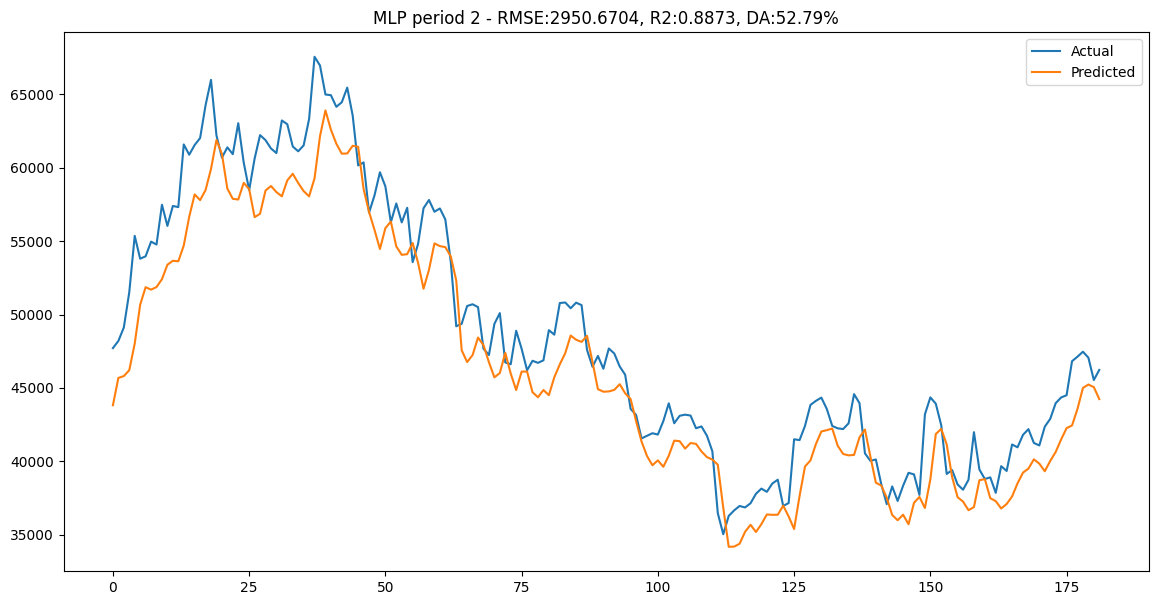

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.title(f"MLP period 2 - RMSE:{rmse:.4f}, R2:{r2:.4f}, DA:{da:.2f}%")
plt.plot(Y_test, label='Actual')
plt.plot(Y_pred, label='Predicted')

plt.legend()
plt.show()

In [16]:
print(best_hps.values)

{'no_layers': 2, 'no_units_0': 128, 'dropout_0': 0.5, 'last_units': 128, 'last_dropout': 0.1, 'no_units_1': 128, 'dropout_1': 0.30000000000000004, 'tuner/epochs': 34, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}


In [17]:
import pickle
name = 'all'
model = 'mlp'
file = open(f"/home/hoangbaoan1901/Documents/information-system_UET/sem5/prdan/tianen101/implementations/results/{name}/{model}.pkl", "wb")
pickle.dump(obj=Y_pred, file=file)
file.close()